In [1]:
! pip list|grep transformers

sentence-transformers              1.1.0
transformers                       4.5.0


In [2]:
! pip install bert-extractive-summarizer

     |████████████████████████████████| 5.9 MB 4.9 MB/s eta 0:00:01
  Using cached wasabi-0.8.2-py3-none-any.whl (23 kB)
     |████████████████████████████████| 10.1 MB 74.2 MB/s eta 0:00:01
     |████████████████████████████████| 125 kB 78.2 MB/s eta 0:00:01
     |████████████████████████████████| 9.9 MB 52.4 MB/s eta 0:00:01
     |████████████████████████████████| 42 kB 1.2 MB/s  eta 0:00:01
     |████████████████████████████████| 451 kB 74.7 MB/s eta 0:00:01
     |████████████████████████████████| 627 kB 71.2 MB/s eta 0:00:01


In [3]:
# read in data
article = []
# titles
titles = []

import os
for root, dirs, files in os.walk("../mao/"):
    for file in files:
        if file.endswith(".txt"):
            print(os.path.join(root, file))
            with open(os.path.join(root, file), "r") as input:
                sentences = input.read()
            article.append(sentences)
            titles.append(file)
            
print(len(article))
print(len(titles))

../mao/REPORT ON AN INVESTIGATION OF THE PEASANT MOVEMENT IN HUNAN.txt
../mao/ON CORRECTING MISTAKEN IDEAS IN THE PARTY.txt
../mao/BE CONCERNED WITH THE WELL-BEING OF THE MASSES, PAY ATTENTION TO METHODS OF WORK.txt
../mao/WHY IS IT THAT RED POLITICAL POWER CAN EXIST IN CHINA.txt
../mao/A SINGLE SPARK CAN START A PRAIRIE FIRE.txt
../mao/ANALYSIS OF THE CLASSES IN CHINESE SOCIETY.txt
6
6


In [4]:
# concatenate text
text = ''.join(article)

len(text)

174475

In [5]:
# remove reference mark, e.g. '[1]'

import re

text = re.sub(r'\[\d{1,3}\]' ,'', text)
len(text)

174164

In [6]:
# using nltk, split text into sentences

from nltk.tokenize import sent_tokenize

sentences = sent_tokenize(text)

len(sentences)

1250

## Using bert-extractive-summarizer

In [7]:
! python -m spacy download en_core_web_md

2021-10-23 13:02:33.947951: W tensorflow/stream_executor/platform/default/dso_loader.cc:60] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /shared/centos7/cuda/10.2/lib64:/shared/centos7/cuda/10.2/extras/CUPTI/lib64:/shared/centos7/anaconda3/3.7/lib:/shared/centos7/nodejs/14.15.4/lib
2021-10-23 13:02:33.948035: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.
     |████████████████████████████████| 45.4 MB 6.0 MB/s eta 0:00:01
✔ Download and installation successful
You can now load the package via spacy.load('en_core_web_md')


In [8]:
! pip install neuralcoref

     |████████████████████████████████| 286 kB 4.8 MB/s eta 0:00:01


In [9]:
from summarizer import Summarizer
model = Summarizer()
result = model(text, min_length=60)
full = ''.join(result)
print(full)


THE IMPORTANCE OF THE PEASANT PROBLEM
During my recent visit to Hunan  I made a first-hand investigation of conditions in the five counties of Hsiangtan, Hsianghsiang, Hengshan, Liling and Changsha. For the present upsurge of the peasant movement is a colossal event. In this period, January to June was a time of underground activity, and July to September, when the revolutionary army was driving out Chao Heng-ti,  one of open activity. The second period, from last October to January of this year, was one of revolutionary action. As a result, the privileges which the feudal landlords enjoyed for thousands of years are being shattered to pieces. The local tyrants, evil gentry and lawless landlords have been deprived of all right to speak, and none of them dares even mutter dissent. Please let me join the peasant association," one of the smaller of the evil gentry will say. In some places the peasants now use this method to scare those who formerly opposed the associations. But more ofte

## compare with our implementation

In [10]:
## get embedding 

from sentence_transformers import SentenceTransformer
model = SentenceTransformer('bert-base-nli-mean-tokens')

sentence_embeddings = model.encode(sentences)

sentence_embeddings

array([[-0.5586639 ,  0.49654362,  0.35135013, ...,  0.3961791 ,
        -0.56102544, -0.5014237 ],
       [-0.63877565,  0.6591971 ,  0.45411998, ...,  0.33426017,
         0.68030334, -0.4105224 ],
       [-0.493588  ,  0.26483166, -0.4166434 , ...,  0.8245905 ,
        -0.5539282 ,  0.3224848 ],
       ...,
       [ 0.00753561,  0.44634074,  0.22721678, ..., -1.176723  ,
        -0.72373253,  0.00716608],
       [-0.54278463,  0.69175357,  0.673795  , ...,  0.3588523 ,
        -0.40322772,  0.49645212],
       [-0.42364797,  0.17863412,  1.2064114 , ..., -0.09976815,
        -1.39035   ,  0.6415326 ]], dtype=float32)

In [11]:
from sklearn.preprocessing import normalize
# normalize the data help k-means get better performance
norm_data = normalize(sentence_embeddings, norm='l2')

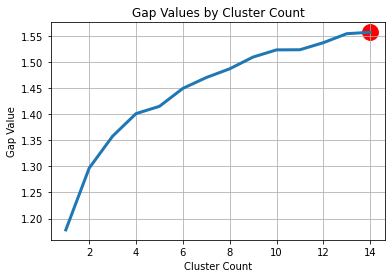

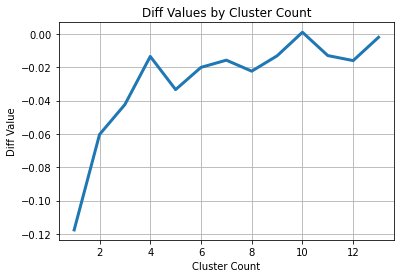

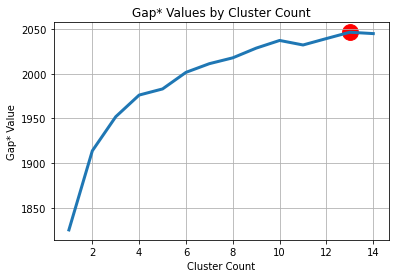

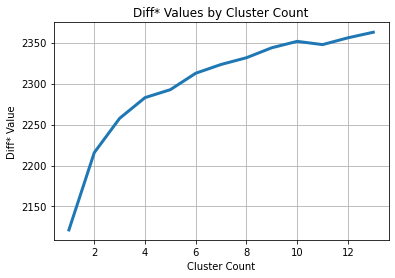

In [12]:
from gap_statistic import OptimalK
import numpy as np
optimalK = OptimalK(n_jobs=4, parallel_backend='joblib')

# limit to 1~15 cluster
n_clusters = optimalK(norm_data, cluster_array=np.arange(1, 15))
optimalK.plot_results()

In [13]:
# using the best K = 13 for k-means
from sklearn.cluster import KMeans
km = KMeans(
    n_clusters=13, init='random',
    n_init=10, max_iter=300, 
    tol=1e-04, random_state=0
)
y_km = km.fit_predict(norm_data)

y_km

array([8, 5, 1, ..., 8, 1, 0], dtype=int32)

In [14]:
## create a array that assign each sentence to its group
groups = []

for i in range (0, 13):
    groups.append([])

for idx, embed in enumerate(norm_data):
    groups[y_km[idx] - 1].append(idx)

In [15]:
def get_sum_distances(group):
    """input a group indicis of sentences, get a list of sum of cosine distance between
    current sentence and other sentences in the text(score)
    @param: a group of index, index of sentence
    @return score(float)
    """
    # construct data for group info
    data = np.array([norm_data[i] for i in group])
    # to store the result
    res = []
    
    for idx, _ in enumerate(data):
        # data has been normalized, cosine distanct can be calculated as np.dot()
        scores = np.dot(data, data[idx].T)
        res.append(np.sum(scores))
    return res

In [16]:
## pick up top score for each group

for idx, group in enumerate(groups):
    score_list = get_sum_distances(group)
    max_idx = np.argmax(score_list)
    print('Group:' + str(idx + 1) + ': \n')
    print(sentences[group[max_idx]])
    print('\n')

Group:1: 

The small handicraftsmen are called semi-proletarians because, though they own some simple means of production and moreover are self-employed, they too are often forced to sell part of their labour power and are somewhat similar to the poor peasants in economic status.


Group:2: 

In all the places under our leadership, there are undoubtedly many active cadres, excellent comrades, who have sprung from the masses.


Group:3: 

B.


Group:4: 

Former hardened gamblers are now themselves suppressing gambling; this abuse, too, has been swept away in places where the peasant association is powerful.


Group:5: 

Yet, surprisingly enough, the peasant associations have now been established several months, and have even dared to stand up to the gentry.


Group:6: 

This is mainly due to.


Group:7: 

Now the peasants are using the checking of accounts as an occasion to bring down a great many of the local tyrants and evil gentry.


Group:8: 

Secondly, one will understand the gravi

In [17]:
# Number of sentences to use = 13

model2 = Summarizer()
result2 = model2(text, min_length=60, num_sentences=13)
full2 = ''.join(result2)
print(full2)

THE IMPORTANCE OF THE PEASANT PROBLEM
During my recent visit to Hunan  I made a first-hand investigation of conditions in the five counties of Hsiangtan, Hsianghsiang, Hengshan, Liling and Changsha. Without the poor peasant class (the "riffraff", as the gentry call them), it would have been impossible to bring about the present revolutionary situation in the countryside, or to overthrow the local tyrants and evil gentry and complete the democratic revolution. The financial authorities once explained the difficulties encountered by the Hunan Provincial Government in raising money by the fact that the peasants were banishing the well-to-do, which gives some idea of the extent to which the local tyrants and evil gentry are not tolerated in their home villages. It is for the peasants themselves to cast aside the idols, pull down the temples to the martyred virgins and the arches to the chaste and faithful widows; it is wrong for anybody else to do it for them. PEASANT BANS AND PROHIBITIONS